## Leer y Descomprimir Dataset

In [1]:
import pandas as pd

# Cargar el dataset
data_file = '/content/jena_climate_2009_2016.csv'
data = pd.read_csv(data_file)
print(data.head())


             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

## Graficar la Temperatura en el Tiempo para Todas las Muestras

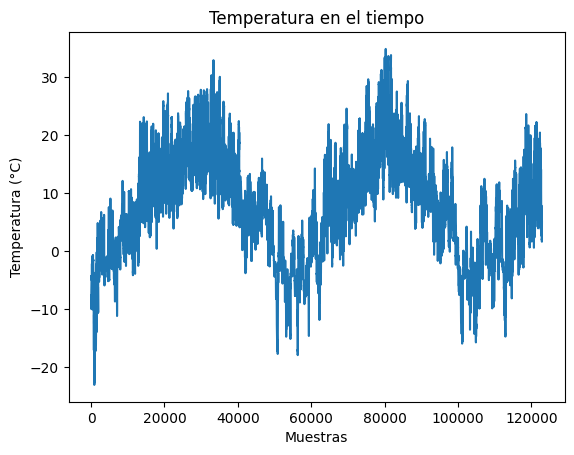

In [3]:
import matplotlib.pyplot as plt

# Selección de la columna de temperatura
y = data['T (degC)'].to_numpy()

# Gráfica de la temperatura en el tiempo
plt.plot(range(len(y)), y)
plt.title('Temperatura en el tiempo')
plt.xlabel('Muestras')
plt.ylabel('Temperatura (°C)')
plt.show()


## Graficar la Temperatura para los Primeros 10 Días (240 Muestras)

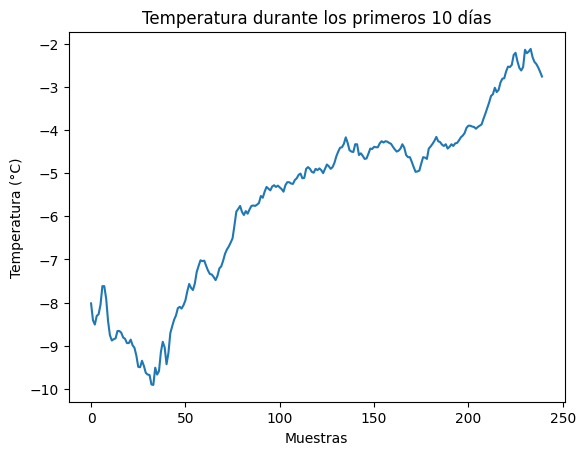

In [4]:
# Gráfica de la temperatura para los primeros 10 días
plt.plot(range(240), y[:240])
plt.title('Temperatura durante los primeros 10 días')
plt.xlabel('Muestras')
plt.ylabel('Temperatura (°C)')
plt.show()


In [5]:
# División de datos: 50% Entrenamiento, 25% Validación, 25% Prueba
No_train = int(len(data) * 0.5)
No_val = int(len(data) * 0.25)
No_test = len(data) - No_train - No_val

print(f'Tamaño del conjunto de entrenamiento: {No_train}')
print(f'Tamaño del conjunto de validación: {No_val}')
print(f'Tamaño del conjunto de prueba: {No_test}')


Tamaño del conjunto de entrenamiento: 61449
Tamaño del conjunto de validación: 30724
Tamaño del conjunto de prueba: 30726


In [6]:
# Separar columnas de entrada y salida, y manejar valores NaN
inputs = data[['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
               'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']]
outputs = data['T (degC)']
inputs = inputs.fillna(inputs.mean())

# Convertir a numpy y estandarizar
X = inputs.to_numpy()
y = outputs.to_numpy()

# Estandarización de los datos de entrada
media = X[:No_train].mean(axis=0)
std = X[:No_train].std(axis=0)
X = (X - media) / std


In [7]:
from tensorflow.keras.utils import timeseries_dataset_from_array

# Parámetros de entrada de secuencia
sampling_rate = 6  # 1 dato cada hora
sequence_length = 120  # Secuencia de 120 horas (5 días)
delay = sampling_rate * (sequence_length + 24 - 1)  # Predicción a 24 horas
batch_size = 256

# Creación de conjuntos de datos en lotes
train_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=0, end_index=No_train
)

val_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train, end_index=No_train + No_val
)

test_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train + No_val
)


In [8]:
for samples, targets in train_dataset:
    print("Dimensiones de samples:", samples.shape)
    print("Dimensiones de targets:", targets.shape)
    break


Dimensiones de samples: (256, 120, 11)
Dimensiones de targets: (256,)


In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Configuración del modelo MLP
model_MLP = Sequential([
    Input(shape=(sequence_length, X.shape[-1])),
    Dense(16, activation="relu"),
    Dense(1)
])

# Compilación y entrenamiento del modelo
model_MLP.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history_MLP = model_MLP.fit(
    train_dataset, epochs=10, validation_data=val_dataset
)

print(f"MAE (Test): {model_MLP.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 119.1641 - mae: 8.8589 - val_loss: 134.1466 - val_mae: 9.7421
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 86.5645 - mae: 7.6380 - val_loss: 94.4891 - val_mae: 7.8302
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 82.2919 - mae: 7.4728 - val_loss: 87.5701 - val_mae: 7.4877
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 81.2434 - mae: 7.4321 - val_loss: 82.9673 - val_mae: 7.2529
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 80.9177 - mae: 7.4262 - val_loss: 81.6099 - val_mae: 7.1838
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 80.2654 - mae: 7.3941 - val_loss: 82.5322 - val_mae: 7.2342
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 80.5507 - mae: 7.4141 - val_loss: 80.9106 - val_mae: 7.1479
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 80.5976 - mae: 7.4139 - val_loss: 80.5560 - val_mae: 7.1291
Epoch 9/10
238/238 ━━━━

In [10]:
from tensorflow.keras.layers import LSTM

# Configuración del modelo LSTM
model_LSTM = Sequential([
    Input(shape=(sequence_length, X.shape[-1])),
    LSTM(64, recurrent_dropout=0.3, return_sequences=True),
    LSTM(32, recurrent_dropout=0.3),
    Dense(1)
])

# Compilación y entrenamiento del modelo
model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_LSTM = model_LSTM.fit(
    train_dataset, epochs=20, validation_data=val_dataset
)

print(f"MAE (Test): {model_LSTM.evaluate(test_dataset)[1]:.2f}")


Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - loss: 65.4866 - mae: 6.1654 - val_loss: 36.3441 - val_mae: 4.5636
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 429ms/step - loss: 17.7508 - mae: 3.1487 - val_loss: 20.3418 - val_mae: 3.3151
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - loss: 11.2995 - mae: 2.5408 - val_loss: 15.9776 - val_mae: 2.9939
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - loss: 9.1112 - mae: 2.3023 - val_loss: 14.2516 - val_mae: 2.8858
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - loss: 7.6074 - mae: 2.1161 - val_loss: 13.4536 - val_mae: 2.8267
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 428ms/step - loss: 6.3975 - mae: 1.9422 - val_loss: 12.8239 - val_mae: 2.7659
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 424ms/step - loss: 5.4198 - mae: 1.7912 - val_loss: 13.0880 - val_mae: 2.8219
Epoch 8/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 424ms/step - loss: 4.7055 - mae: 1.6671 - val_loss: 13.4189 - val_mae: 2.8860
Epoch 9/20
23

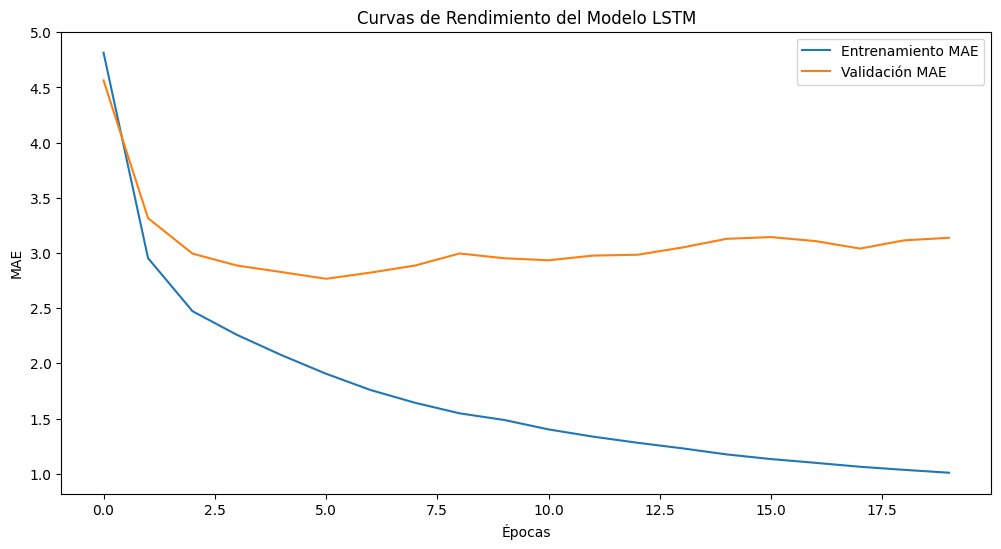

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(history_LSTM.history['mae'], label='Entrenamiento MAE')
plt.plot(history_LSTM.history['val_mae'], label='Validación MAE')
plt.title('Curvas de Rendimiento del Modelo LSTM')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ajuste del sequence_length
sequence_length = 60  # Reducción a 60 para captar patrones más a corto plazo

# Modelo ajustado con BatchNormalization y LSTM bidireccional
model_optimized = Sequential([
    Input(shape=(sequence_length, X.shape[-1])),
    BatchNormalization(),
    Bidirectional(LSTM(64, recurrent_dropout=0.3, return_sequences=True)),
    BatchNormalization(),
    LSTM(32, recurrent_dropout=0.2),
    Dense(1)
])

# Compilación con el optimizador Nadam
optimizer = Nadam(learning_rate=0.001)
model_optimized.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks para reducción de tasa de aprendizaje y parada temprana
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del modelo
history_optimized = model_optimized.fit(
    train_dataset, epochs=50, validation_data=val_dataset,
    callbacks=[reduce_lr, early_stop]
)

# Evaluación en el conjunto de prueba
test_mae_optimized = model_optimized.evaluate(test_dataset)[1]
print(f"MAE en el conjunto de prueba (modelo optimizado): {test_mae_optimized:.2f}")


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 155s 628ms/step - loss: 59.0171 - mae: 5.7421 - val_loss: 35.6790 - val_mae: 4.3846 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 201s 626ms/step - loss: 16.5223 - mae: 2.9850 - val_loss: 20.5110 - val_mae: 3.3173 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 150s 628ms/step - loss: 10.0310 - mae: 2.3591 - val_loss: 16.2972 - val_mae: 3.0374 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 149s 627ms/step - loss: 7.3068 - mae: 2.0431 - val_loss: 15.1509 - val_mae: 3.0112 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 199s 613ms/step - loss: 5.8567 - mae: 1.8334 - val_loss: 15.0540 - val_mae: 3.0247 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 150s 630ms/step - loss: 4.6730 - mae: 1.6353 - val_loss: 13.8924 - val_mae: 2.9444 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 147s 617ms/step - loss: 3.8758 - mae: 1.4942 - val_loss: 13.7683 - val_mae:

In [1]:
plt.figure(figsize=(12, 6))
plt.plot(history_optimized.history['mae'], label='Entrenamiento MAE')
plt.plot(history_optimized.history['val_mae'], label='Validación MAE')
plt.title('Curvas de Rendimiento del Modelo LSTM Optimizado')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()


NameError: name 'plt' is not defined